## Описание проекта


Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**
**Тариф «Смарт»**

    - Ежемесячная плата: 550 рублей
    - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    - Стоимость услуг сверх тарифного пакета:
        - минута разговора: 3 рубля
        - сообщение: 3 рубля
        - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

    - Ежемесячная плата: 1950 рублей
    - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    - Стоимость услуг сверх тарифного пакета:
        - минута разговора: 1 рубль
        - сообщение: 1 рубль
        - 1 Гб интернет-трафика: 150 рублей

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

**Таблица users (информация о пользователях):**

    - user_id — уникальный идентификатор пользователя
    - first_name — имя пользователя
    - last_name — фамилия пользователя
    - age — возраст пользователя (годы)
    - reg_date — дата подключения тарифа (день, месяц, год)
    - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    - city — город проживания пользователя
    - tariff — название тарифного плана

**Таблица calls (информация о звонках):**

    - id — уникальный номер звонка
    - call_date — дата звонка
    - duration — длительность звонка в минутах
    - user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

    - id — уникальный номер сообщения
    - message_date — дата сообщения
    - user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

    - id — уникальный номер сессии
    - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    - session_date — дата интернет-сессии
    - user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

    - tariff_name — название тарифа
    - rub_monthly_fee — ежемесячная абонентская плата в рублях
    - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    - messages_included — количество сообщений в месяц, включённых в абонентскую плату
    - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import calendar
import seaborn as sns

from scipy.stats import bartlett
from scipy import stats
from statsmodels.stats import weightstats as stests
from IPython.display import display
from functools import reduce
idx = pd.IndexSlice
from scipy import stats as st

In [2]:
# cal = pd.read_csv('mobile/calls.csv')
# inet = pd.read_csv('mobile/internet.csv')
# msg = pd.read_csv('mobile/messages.csv')
# trf = pd.read_csv('mobile/tariffs.csv')
# usr = pd.read_csv('mobile/users.csv')

cal = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv') # код ревьюера
inet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv') # код ревьюера
msg = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv') # код ревьюера
trf = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv') # код ревьюера
usr = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv') # код ревьюера

## Изучение общих данных из файлов

### Информация о звонках

In [3]:
cal.sample(5)

,id,call_date,duration,user_id
15371,1041_69,2018-12-22,0.00,1041
194677,1477_425,2018-08-08,10.56,1477
6020,1017_216,2018-09-06,0.00,1017
120718,1312_48,2018-08-29,10.03,1312
5768,1015_488,2018-12-02,1.26,1015


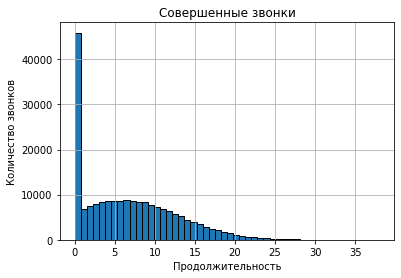

In [4]:
cal['duration'].plot(kind='hist', ec='black', bins=50)
plt.title("Совершенные звонки")
plt.xlabel("Продолжительность")
plt.ylabel("Количество звонков")
plt.grid(True)
plt.show()

In [7]:
plt.rcParams["figure.figsize"] = (15, 7)

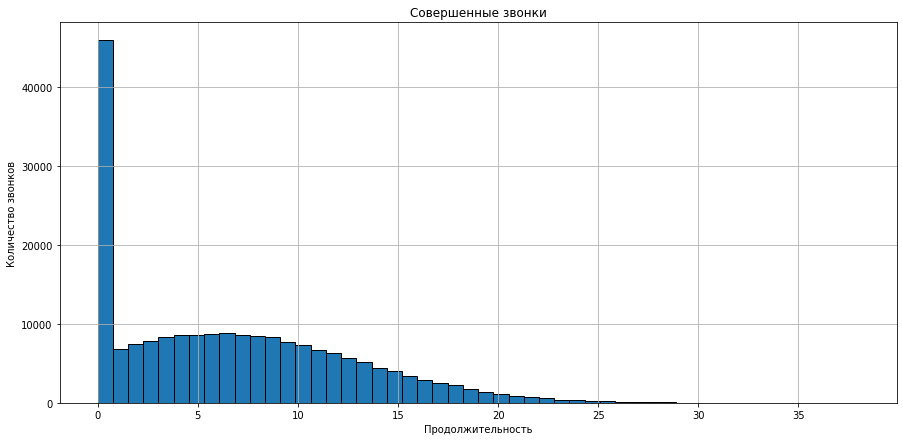

In [8]:
cal['duration'].plot(kind='hist', ec='black', bins=50)
plt.title("Совершенные звонки")
plt.xlabel("Продолжительность")
plt.ylabel("Количество звонков")
plt.grid(True)
plt.show()

In [5]:
# проверим сколько звонков по продолжительности составляют меньше минуты.
print(len(cal[cal.duration == 0]))
print(len(cal[cal.duration < 1]))

39613
47927


In [6]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


✔️ Данные о звонках в полном объеме, без пропусков, но есть нули, которые необходимо будет удалить, так как скорее всего это несостоявшиеся звонки,  которые не принимают участия в формировании конечной выручки. Данные о времени разговоров в отрезке от 0,1 до минуты округлим до 1, так как скорее всего плата взымается как за целую. Потребуется замена типа в столбце с датой, и огруглить минуты разговора.

### Информация об интернет-сессиях

In [7]:
inet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
19398,19398,1065_543,447.39,2018-09-29,1065
136859,136859,1458_237,617.89,2018-10-02,1458
72408,72408,1244_240,0.00,2018-05-14,1244
136880,136880,1458_258,289.34,2018-06-23,1458
112791,112791,1381_380,325.56,2018-01-22,1381


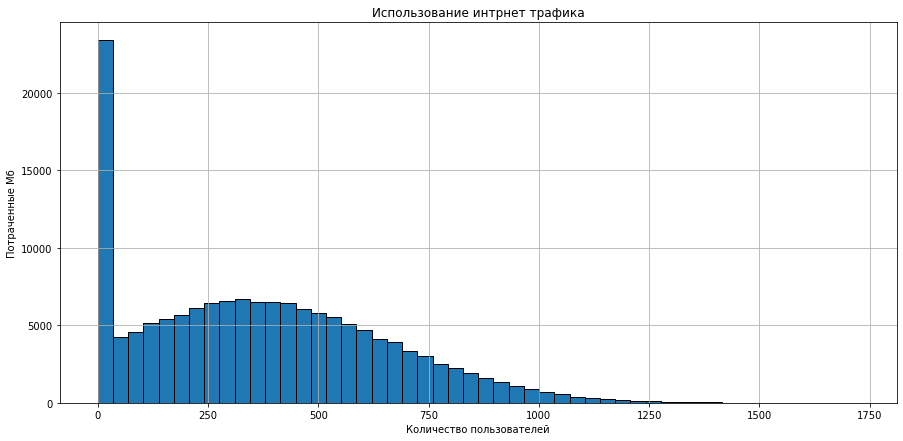

In [9]:
inet['mb_used'].plot(kind='hist', ec='black', bins=50)
plt.title("Использование интрнет трафика")
plt.xlabel("Количество пользователей")
plt.ylabel("Потраченные Мб")
plt.grid(True)
plt.show()

In [9]:
inet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
print(len(inet[inet.mb_used == 0]))
print(len(inet[inet.mb_used < 1]))

19598
19699


✔️ По интернет трафику данные также в полном объеме; пропусков нет, но наблюдается множество нулей, возможно выход осуществлялся в социальные сети, по которым трафик по тарифу скорее всего бесплатный. Раз эти данные не будут влиять на общуую выручку, их нужно будут также удалить. По значениям в отрезке от 0,1 до 1 округлим в большую сторону как указал опертор до 1. Также в таблице присутствует столбец "Unnamed: 0" без описания в задании и совпадающий с номером по П/п., его можно удалить. 

### Информация о сообщениях

In [11]:
msg.sample(5)

,id,message_date,user_id
113064,1457_113,2018-08-02,1457
18830,1083_19,2018-12-29,1083
92472,1381_425,2018-09-20,1381
4519,1018_57,2018-09-20,1018
19630,1087_28,2018-12-21,1087


In [12]:
msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


✔️ Данные по сообщениям в полном объеме, без пропусков. Необходимо будет привести дату также в соответствующий формат.

### Информация о тарифах

In [13]:
trf.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [14]:
trf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


✔️ Данные чистые.

### Информация о пользователях

In [15]:
usr.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
32,1032,31,NaN,Ульяновск,Инна,Игнатьева,2018-01-04,smart
69,1069,36,NaN,Екатеринбург,Гордей,Кочетов,2018-12-10,smart
151,1151,39,NaN,Пенза,Лариса,Молчанова,2018-09-15,ultra
37,1037,73,NaN,Череповец,Изольда,Архипова,2018-10-13,smart
68,1068,34,NaN,Москва,Ким,Демьянов,2018-07-16,smart


In [16]:
usr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [17]:
usr.columns = ['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name']

✔️ Данные по пользователям в полном объеме, кроме информации о дате прекращения пользования тарифом, где пропуски означают что клиент продолжает пользоваться тарифом. 

# Вывод

**Датасет содержит данные по 500 клиентам, потребуется заменить тип данных у столбцов с датой и временем, а также округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам. Кроме того, после объединения данных (сводная таблица по звонкам, по сообщениям и интернет-трафику) возникнут пропущенные значения (клиент мог в каком-то месяце не писать сообщений, но звонить и использовать интернет), которые также нужно будет заменить на нули.**

## Обработка данных

- Приведите данные к нужным типам;

- Найдите и исправьте ошибки в данных.

In [18]:
#Заменим тип данных, обозначающих дату, со строчного на временной:
cal['call_date'] = pd.to_datetime(cal['call_date'], format='%Y-%m-%d')
inet['session_date'] = pd.to_datetime(inet['session_date'], format='%Y-%m-%d')
msg['message_date'] = pd.to_datetime(msg['message_date'], format='%Y-%m-%d')
usr['churn_date'] = pd.to_datetime(usr['churn_date'], format='%Y-%m-%d')
usr['reg_date'] = pd.to_datetime(usr['reg_date'], format='%Y-%m-%d')

In [19]:
#округлим значения по продолжительности звонков до 1 и удалим строки с 0
cal['duration'] = cal['duration'].apply(np.ceil)
cal['duration'] = cal['duration'].replace(0, np.NaN)
cal = cal.dropna()
cal['duration'] = cal['duration'].astype(int)

In [20]:
#проверим замену
len(cal[cal.duration < 1])

0

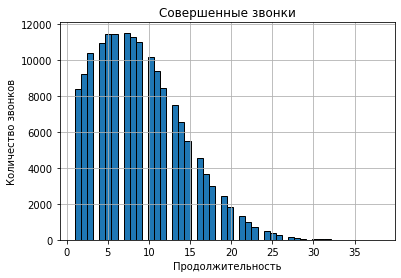

In [21]:
#посмотрим на графике
cal['duration'].plot(kind='hist', ec='black', bins=50)
plt.title("Совершенные звонки")
plt.xlabel("Продолжительность")
plt.ylabel("Количество звонков")
plt.grid(True)
plt.show()

In [22]:
#округлим по инет трафику все значения в большую сторону, а нулевые значения заменим на 1.
inet['mb_used'] = inet['mb_used'].apply(np.ceil)
inet['mb_used'] = inet['mb_used'].replace(0, np.NaN)
inet = inet.dropna()
inet['mb_used'] = inet['mb_used'].astype(int)

In [23]:
#удалим непонятный столбец в инет сессии
inet = inet.drop('Unnamed: 0',axis=1)
inet.dtypes

id                      object
mb_used                  int64
session_date    datetime64[ns]
user_id                  int64
dtype: object

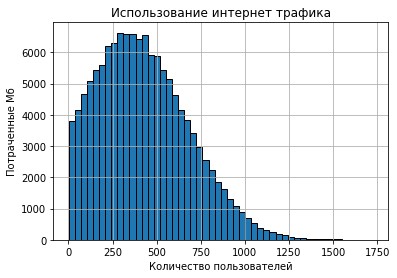

In [24]:
#посмотрим на графике
inet['mb_used'].plot(kind='hist', ec='black', bins=50)
plt.title("Использование интернет трафика")
plt.xlabel("Количество пользователей")
plt.ylabel("Потраченные Мб")
plt.grid(True)
plt.show()

In [25]:
#добавим столбцы с месяцами
cal['month'] = cal['call_date'].values.astype('datetime64[M]')
usr['month'] = usr['reg_date'].values.astype('datetime64[M]')
msg['month'] = msg['message_date'].values.astype('datetime64[M]')
inet['month'] = inet['session_date'].values.astype('datetime64[M]')

**Посчитайте для каждого пользователя:**
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

<div style="border:solid purple 5px; padding: 20px"> 
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>

<h3> Красивый print() <a class="tocSkip"> </h3>

Мы очень часто отлаживаем код и пользуемся функцией `print`. Вывод в одну строку не всегда удобен. К примеру, когда мы делаем запрос серверу и получаем огромный json. Встроенный модуль pprint поможет нам навести красоту. С каждым новым вложением он делает дополнительный отступ и вывод всегда радует глаз. Вот [документация](https://docs.python.org/3/library/pprint.html) на сам модуль. Кстати, мы можем переопределить стандартную функцию print написав `print = pprint.pprint`

Ниже приведен пример кода. Вы можете самостоятельно поэкспериментировать с модулем.

![](https://i.ibb.co/353GvhX/image.png)

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [26]:
user_cal = cal.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})\

In [27]:
user_cal.sort_values(by = 'month_calls_duration', ascending=False).head(3)

,user_id,month,month_calls_duration,calls_total_in_month
2966,1467,2018-12-01,1673,190
2353,1377,2018-03-01,1609,165
1359,1216,2018-12-01,1435,162


### Количество отправленных сообщений по месяцам

In [28]:
user_msg = msg.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total_in_month'})

In [29]:
user_msg.head(3)

,user_id,month,sms_total_in_month
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75


### Объем израсходованного интернет-трафика по месяцам

In [30]:
user_inet = inet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total_in_month'})

In [31]:
user_inet.head(3)

,user_id,month,mb_total_in_month
0,1000,2018-05-01,2256
1,1000,2018-06-01,23257
2,1000,2018-07-01,14016


### Помесячная выручка с каждого пользователя

In [32]:
cl = user_cal.merge(user_msg, on=['user_id','month'], how='outer')
cl = cl.merge(user_inet, on=['user_id','month'], how = 'outer')
cl = cl.merge(usr, on='user_id', how='left')
cl = cl.merge(trf, on='tariff_name', how='left')

In [33]:
cl.head(7)

,user_id,month_x,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,reg_date,tariff_name,month_y,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,2018-05-01,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,2018-05-01,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,2018-05-01,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,2018-05-01,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,2018-05-01,1000,30720,3000,1950,150,1,1
5,1000,2018-10-01,350.0,44.0,73.0,14717.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,2018-05-01,1000,30720,3000,1950,150,1,1
6,1000,2018-11-01,338.0,37.0,58.0,14768.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,2018-05-01,1000,30720,3000,1950,150,1,1


In [34]:
#после слияния таблиц проверим на возможно появившиеся пропуски
cl.isna().sum()

user_id                     0
month_x                     0
month_calls_duration       46
calls_total_in_month       46
sms_total_in_month        497
mb_total_in_month          13
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff_name                 0
month_y                     0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [35]:
#заменим появившиеся пропуски на 0, это абоненты которые не тратятся на звонки, сообщения или интернет
cl['sms_total_in_month'] = cl['sms_total_in_month'].fillna(0).astype(int)
cl['mb_total_in_month'] = cl['mb_total_in_month'].fillna(0).astype(int)
cl['month_calls_duration'] = cl['month_calls_duration'].fillna(0).astype(int)
cl['calls_total_in_month'] = cl['calls_total_in_month'].fillna(0).astype(int)

In [36]:
cl.isna().sum()

user_id                     0
month_x                     0
month_calls_duration        0
calls_total_in_month        0
sms_total_in_month          0
mb_total_in_month           0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff_name                 0
month_y                     0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [37]:
#проверим также дубликаты
cl.duplicated().sum()

0

In [38]:
#теперь напишем функцию подсчета выручки
def revenue(row):
    sms = (row['sms_total_in_month'] - row['messages_included']) * row['rub_per_message']
    mins = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    mbs = np.ceil((row['mb_total_in_month'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024)
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total

In [39]:
#добавим расчеты по каждому пользователю в таблицу
cl['revenue'] = cl.apply(lambda x: revenue(x), axis=1)

In [40]:
#добавим итоговый расчет
cl['total_paid'] = cl['rub_monthly_fee'] + cl['revenue']

In [41]:
#посмотрим что получилось
cl.sort_values(by='total_paid', ascending=False).head()

,user_id,month_x,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,month_y,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue,total_paid
3100,1486,2018-12-01,1007,115,83,38610,35,NaT,Нижний Новгород,Матвей,...,2018-10-01,50,15360,500,550,200,3,3,6162.0,6712.0
1618,1261,2018-12-01,1074,113,22,32697,46,NaT,Казань,Мадина,...,2018-10-01,50,15360,500,550,200,3,3,5109.0,5659.0
260,1042,2018-12-01,728,94,75,37219,42,NaT,Хабаровск,Константин,...,2018-11-01,50,15360,500,550,200,3,3,5029.0,5579.0
3099,1486,2018-11-01,764,84,96,36319,35,NaT,Нижний Новгород,Матвей,...,2018-10-01,50,15360,500,550,200,3,3,5024.0,5574.0
1789,1286,2018-12-01,739,83,68,35151,19,NaT,Москва,Рашид,...,2018-11-01,50,15360,500,550,200,3,3,4637.0,5187.0


In [42]:
cl['month_x'] = cl['month_x'].values.astype('datetime64[M]')

## Анализ данных

- Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### Общая информация

In [43]:
smart = cl.query('tariff_name=="smart"')
ultra = cl.query('tariff_name=="ultra"')
print('Количество минут разговора в месяц на тарифе "Смарт" составляет - {:.0f}'.format(smart['month_calls_duration'].sum()/12),', на тарифе "Ультра" - {:.0f}'.format(ultra['month_calls_duration'].sum()/12))
print('Количество сообщений в месяц на тарифе "Смарт" составляет - {:.0f}'.format(smart['sms_total_in_month'].sum()/12),', на тарифе "Ультра" - {:.0f}'.format(ultra['sms_total_in_month'].sum()/12))
print('Объем трафика (в Гб) в месяц на тарифе "Смарт" составляет - {:.0f}'.format(smart['mb_total_in_month'].sum()/1024/12),', на тарифе "Ультра" - {:.0f}'.format(ultra['mb_total_in_month'].sum()/1024/12))      

Количество минут разговора в месяц на тарифе "Смарт" составляет - 77631 , на тарифе "Ультра" - 43227
Количество сообщений в месяц на тарифе "Смарт" составляет - 6201 , на тарифе "Ультра" - 4052
Объем трафика (в Гб) в месяц на тарифе "Смарт" составляет - 2944 , на тарифе "Ультра" - 1562


In [44]:
#посчитаем среднее количество, дисперсию и стандартное отклонение
metrics=cl.groupby(['tariff_name']).agg({'total_paid' : ['mean', lambda x: np.var(x, ddof=1), lambda x: np.std(x, ddof=1)]}).reset_index().round(2)
metrics.set_axis(['tariff_name', 'total_paid', 'var', 'std'], axis = 'columns', inplace = True)
metrics

,tariff_name,total_paid,var,std
0,smart,1233.64,620699.73,787.84
1,ultra,2060.60,127060.63,356.46


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 7000)

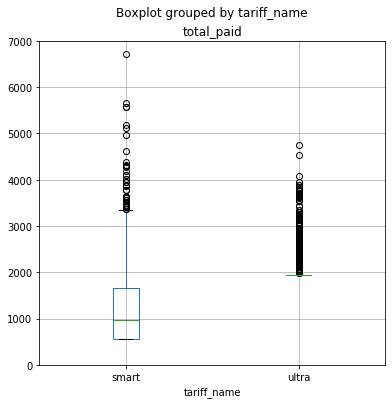

In [45]:
#построим диаграммы размаха для каждого тарифа.

cl.boxplot('total_paid', by='tariff_name', figsize=(6,6)).set_ylim(0,7000)

(0, 5000)

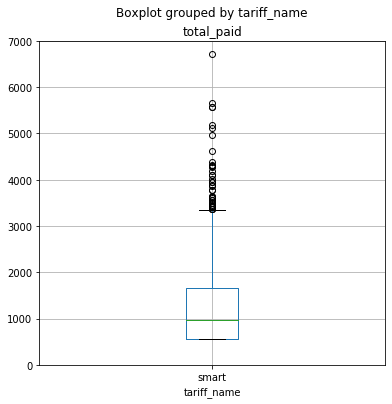

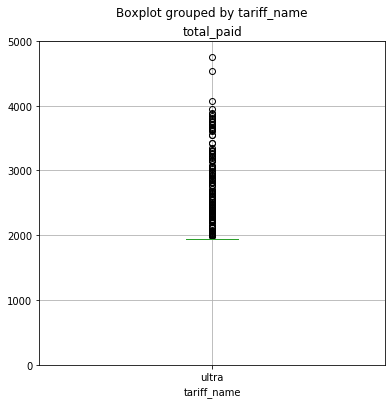

In [46]:
cl_smart_bx = cl[cl['tariff_name'] == "smart"]
cl_ultra_bx = cl[cl['tariff_name'] == "ultra"]
cl_smart_bx.boxplot('total_paid', by='tariff_name', figsize=(6,6)).set_ylim(0,7000)
cl_ultra_bx.boxplot('total_paid', by='tariff_name', figsize=(6,6)).set_ylim(0,5000)

In [47]:
#рассчитаем максимальные значения с применением правил трех сигм, все что больше будем считать выбросами.
parameters_s = smart[['total_paid']].describe().T
q1_s, q2_s = parameters_s['25%'][0], parameters_s['75%'][0]
iqr_s = q2_s - q1_s
max_value_s = q2_s + 3*iqr_s
display(max_value_s)
display(parameters_s)

5026.0

,count,mean,std,min,25%,50%,75%,max
total_paid,2229.0,1233.641095,787.844994,550.0,550.0,960.0,1669.0,6712.0


In [48]:
parameters_u = ultra[['total_paid']].describe().T
q1_u, q2_u = parameters_u['25%'][0], parameters_u['75%'][0]
iqr_u = q2_u - q1_u
max_value_u = q2_u + 3*iqr_u
max_value_u
display(max_value_u)
display(parameters_u)

1950.0

,count,mean,std,min,25%,50%,75%,max
total_paid,985.0,2060.598985,356.45565,1950.0,1950.0,1950.0,1950.0,4744.0


In [49]:
#избавимся от выбросов
cl =cl.drop(cl[(cl.tariff_name == 'smart') & (cl.total_paid > 5022)].index)
cl =cl.drop(cl[(cl.tariff_name == 'ultra') & (cl.total_paid > 1950)].index)

In [50]:
#Посчитаем минуты разговора, сообщения и объем трафика на пользователя в месяц.
cl_pivot = cl.pivot_table(index = ["tariff_name", "month_x"], values = ["month_calls_duration", "sms_total_in_month", "mb_total_in_month"], aggfunc="sum").reset_index()

In [51]:
cl_pivot = cl_pivot.sort_values(by = 'month_x')
cl_pivot.head()

,tariff_name,month_x,mb_total_in_month,month_calls_duration,sms_total_in_month
0,smart,2018-01-01,289831,6931,620
12,ultra,2018-01-01,118382,3853,304
1,smart,2018-02-01,673461,17324,1397
13,ultra,2018-02-01,217671,6340,381
2,smart,2018-03-01,1164537,30034,2453


In [52]:
cl_pivot_smart = cl_pivot.query("tariff_name == 'smart'").set_index("month_x")
cl_pivot_ultra = cl_pivot.query("tariff_name == 'ultra'").set_index("month_x")

### Сравнение суммарной выручки за год по каждому из тарифов:

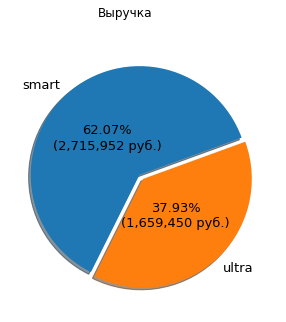

In [53]:
all_cl = cl['total_paid'].sum()
def func_pct(pct):
    value = float(pct/100.*all_cl)
    return "{:.2f}%\n({:,.0f} руб.)".format(pct, value)
explode = (0.05, 0)
axes = cl.groupby('tariff_name')['total_paid'].sum().plot(kind='pie', subplots=True, fontsize=13,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Выручка', pctdistance=0.45,
                                                                     startangle=20, figsize=(20,5),
                                                                     autopct=lambda pct: func_pct(pct))
for ax in axes:
      ax.set_ylabel('')

### Анализ звонков за месяц


In [54]:
cls = ['month_calls_duration']

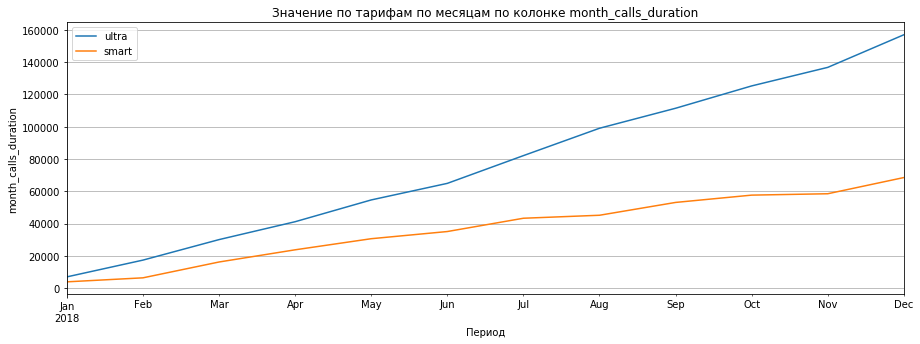

In [55]:
for i in cls: 
    figure(num=None, figsize=(15, 5), facecolor='w', edgecolor='k')
    cl_pivot_smart[i].plot()
    cl_pivot_ultra[i].plot()
    plt.title("Значение по тарифам по месяцам по колонке {}".format(i))
    plt.xlabel("Период")
    plt.ylabel(i)
    plt.legend(["ultra", "smart"])
    plt.grid(True)
    plt.show()

In [56]:
cl.groupby('tariff_name')\
  .agg({'month_calls_duration':['median','mean','var','std']})\
  .style.format("{:.0f}")

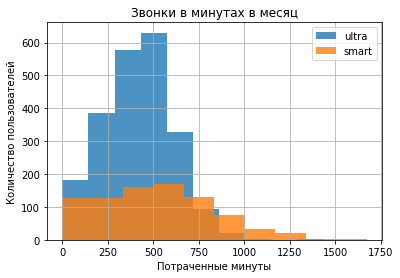

In [57]:
cl[cl['tariff_name'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10, alpha = 0.8)
cl[cl['tariff_name'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10, alpha = 0.8)
plt.legend(["ultra", "smart"])
plt.title('Звонки в минутах в месяц')
plt.xlabel("Потраченные минуты")
plt.ylabel("Количество пользователей")
plt.grid(True)
plt.show()

✔️ Судя по графику, на Смарте большинство людей в месяц говорят около 450 минут, на Ультре 550 минут в месяц. То есть на Смарте люди подходят к краю своего тарифа, а на Ультре у них остается запас 2500 минут. Среднее и медиана лежат рядом и там и там — ничего экстримального.

### Анализ интернет трафика за месяц

In [58]:
cls = ['mb_total_in_month']

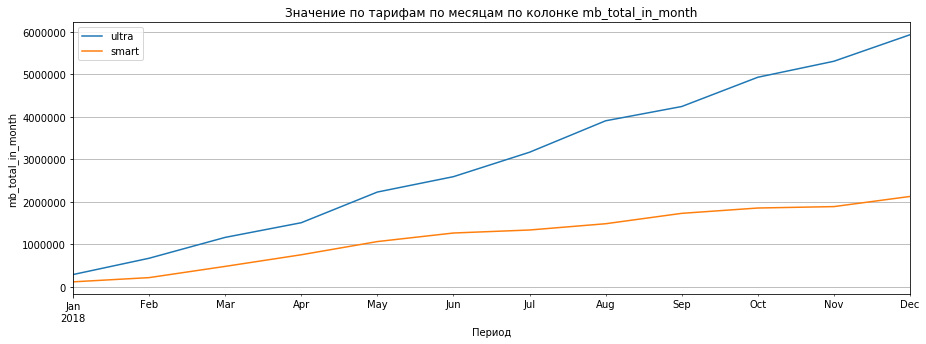

In [59]:
for i in cls: 
    figure(num=None, figsize=(15, 5), facecolor='w', edgecolor='k')
    cl_pivot_smart[i].plot()
    cl_pivot_ultra[i].plot()
    plt.title("Значение по тарифам по месяцам по колонке {}".format(i))
    plt.xlabel("Период")
    plt.ylabel(i)
    plt.legend(["ultra", "smart"])
    plt.grid(True)
    plt.show()

In [60]:
cl.groupby('tariff_name')\
  .agg({'mb_total_in_month':['median','mean','var','std']})\
  .style.format("{:.0f}")

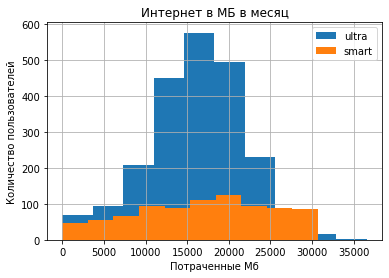

In [61]:
cl[cl['tariff_name'] == 'smart']['mb_total_in_month'].plot(kind='hist', bins=10)
cl[cl['tariff_name'] == 'ultra']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.legend(["ultra", "smart"])
plt.title('Интернет в МБ в месяц')
plt.xlabel("Потраченные Мб")
plt.ylabel("Количество пользователей")
plt.grid(True)
plt.show()

✔️ Среднее и медиана лежат рядом и там и там и тут тоже. На Смарте люди выходят за пределы тарифа больше, у Ультры снова запас — в 10 Гб, но и разброс больше

### Анализ сообщений за месяц

In [62]:
cls = ['sms_total_in_month']

In [ ]:
for i in cls: 
    figure(num=None, figsize=(15, 5), facecolor='w', edgecolor='k')
    cl_pivot_smart[i].plot()
    cl_pivot_ultra[i].plot()
    plt.title("Значение по тарифам по месяцам по колонке {}".format(i))
    plt.xlabel("Период")
    plt.ylabel(i)
    plt.legend(["ultra", "smart"])
    plt.grid(True)
    plt.show()

In [ ]:
cl.groupby('tariff_name')\
  .agg({'sms_total_in_month':['median','mean','var','std']})\
  .style.format("{:.0f}")

<div style="border:solid purple 5px; padding: 20px"> 
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>

<h3> Встроенные функции all() и any() <a class="tocSkip"> </h3>

Полезные функции, которые помогут узнать есть ли определенные значения в объекте.

`all` возвращает **True**, если все объекты равны **True** или удовлетворяют условию

![](https://i.ibb.co/NKs2yWq/image.png)

`any` в свою очередь делает то же самое, но возвращает **True**,если хотя бы один равен **True**

![](https://i.ibb.co/4tq8TmV/image.png)

In [ ]:
cl[cl['tariff_name'] == 'smart']['sms_total_in_month'].plot(kind='hist', bins=10)
cl[cl['tariff_name'] == 'ultra']['sms_total_in_month'].plot(kind='hist', bins=10)
plt.legend(["ultra", "smart"])
plt.title('СМС в месяц')
plt.xlabel("Потраченные СМС")
plt.ylabel("Количество пользователей")
plt.grid(True)
plt.show()


✔️ Поведение пользователей выглядит похожим. Месседжеры работающие на интренете практически уже полностью заменили смс.

**Вывод**
Пользователи тарифа ultra активнее пользутся услугами связи, интернета и сообщений в году. Также по обоим тарифам наблюдается восходящий тренд с течением времени. Разрыв между тарифами увеличивается к окночанию года, в начале года разница не такая большая.

### Среднее, стандартное отклонение и дисперсия по тарифам

In [ ]:
#посчитаем среднее, стандартное отклонение и дисперсию
cl_pivot_agg = cl.pivot_table(index = "tariff_name", values = ['month_calls_duration', 'mb_total_in_month', 'sms_total_in_month'],aggfunc=[np.mean, np.var, np.std]).reset_index().T

In [ ]:
cl_pivot_agg

In [ ]:
msg_usr = msg.merge(usr,how='left',on=['user_id'])

In [ ]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
msg_usr.groupby(['user_id', "tariff_name"])['message_date'].agg(['count']).reset_index().query("tariff_name == 'smart'")\
["count"].hist(alpha=0.6, bins=100)
msg_usr.groupby(['user_id', "tariff_name"])['message_date'].agg(['count']).reset_index().query("tariff_name == 'ultra'")\
["count"].hist(bins=100)
plt.title("Распределение количества сообщений")
plt.xlabel("Дата")
plt.ylabel("Количество значений")
plt.legend(["smart", "ultra"])
plt.grid(True)
plt.show()

✔️ Распределение количества сообщений по пользователям по обоим тарифам скошено вправо. Пик по тарифу smart находится в промежутке от нуля до 100 сообщений, ярко выраженных пиков в тарифе ultra не наблюдается.

In [ ]:
cal_usr = cal.merge(usr,how='left',on=['user_id'])

In [ ]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
cal_usr.query("tariff_name == 'smart'")["duration"].hist(alpha=0.6, bins=60, range=(0.001, max(cal_usr["duration"])))
cal_usr.query("tariff_name == 'ultra'")["duration"].hist(bins=60, range=(0.001, max(cal_usr["duration"])))
plt.title("Распределение длительности звонков")
plt.xlabel("Длительность")
plt.ylabel("Количество значений")
plt.legend(["smart", "ultra"])
plt.grid(True)
plt.show()

✔️ Пользователи тарифа ultra чаще используют около 500 мб, пользователи тарифа smart - 260-270. Распределение тарифа ultra более плоское, без ярко выраженных пиков. Правые хвосты распределений практически совпадают, значит примерно одинаковое количество пользователей в этих тарифах использует крайние значения количества мб.

# Вывод

- Средняя длительность разговора, использание мб и сообщений у тарифа Smart больше.
- Стандартное отклонение у тарифа Smart тоже выше, значит данные более изменчивы в этом тарифе.
- Из графиков можно сделать следующий вывод: пользователи тарифа Smart активнее пользутся услугами оператора.

## Проверка гипотез

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

✔️ При проверке гипотез о равенстве среднего будем применять метод Z-тест (z-критерий Фишера), т.к. будем проводить сравнения двух независимых выборок большого размера. Критический уровень статистической значимости примем равным 5%.

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

- H0 - средняя выручка пользователей тарифов «Смарт» и «Ультра» не различается
- H1 - средняя выручка пользователей тарифов «Смарт» и «Ультра» различается



In [ ]:
alpha=0.05
ztest, pval1 = stests.ztest(cl.query("tariff_name=='smart'")['total_paid'],
                            cl.query("tariff_name=='ultra'")['total_paid'])
print('p-value:', float(pval1))
if pval1 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

✔️ Средняя выручка по тарифам не одинакова, и практически нулевая вероятность говорит о том, что случайно получить такое отличие в значениях практически не получится. Следовательно, средняя выручка пользователей тарифов "Ультра" и "Смарт" действительно различается и наша гипотеза подтвердилась.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

- H0 - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов



In [ ]:
cl_ct=cl.merge(usr,how='left',on=['user_id'])
alpha=0.05
ztest, pval1 = stests.ztest(cl_ct.query('city_x=="Москва"')['total_paid'],
                            cl_ct.query('city_x!="Москва"')['total_paid'])
print('p-value:', float(pval1))
if pval1 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

✔️Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, так как значение статистической  значимости больше критического уровня статистической значимости.

## Вывод

### Cоберем общие данные по тарифам по части использования включенных в абонентскую плату лимитов и сверх лимита:

In [ ]:
smart_mean_internet = (cl[(cl['tariff_name'] == 'smart')]['mb_total_in_month']/(1024 * 15)).mean()
print('Средний процент использования пакета интернет-трафика по тарифу "Смарт" - {:.2%} = {:,.0f} Гб'.
      format(smart_mean_internet, smart_mean_internet * 1024 * 15))
smart_mean_calls = (cl[(cl['tariff_name'] == 'smart')]['month_calls_duration']/(500)).mean()
print('Средний процент использования пакета минут по тарифу "Смарт" - {:.2%} = {:.2f} мин'.
      format(smart_mean_calls, smart_mean_calls * 500))
smart_mean_sms = (cl[(cl['tariff_name'] == 'smart')]['sms_total_in_month']/(50)).mean()
print('Средний процент использования пакета СМС по тарифу "Смарт" - {:.2%} = {:.0f} шт.'.
      format(smart_mean_sms, smart_mean_sms * 50))
print('---------------------------------------------------------------------------------')
ultra_mean_internet = (cl[(cl['tariff_name'] == 'ultra')]['mb_total_in_month']/(1024 * 30)).mean()
print('Средний процент использования пакета интернет-трафика по тарифу "Ультра" - {:.2%} = {:,.0f} Гб'.
      format(ultra_mean_internet, ultra_mean_internet * 1024 * 30))
ultra_mean_calls = (cl[(cl['tariff_name'] == 'ultra')]['month_calls_duration']/(3000)).mean()
print('Средний процент использования пакета минут по тарифу "Ультра" - {:.2%} = {:.2f} мин'.
      format(ultra_mean_calls, ultra_mean_calls * 3000))
ultra_mean_sms = (cl[(cl['tariff_name'] == 'ultra')]['sms_total_in_month']/(1000)).mean()
print('Средний процент использования пакета СМС по тарифу "Ультра" - {:.2%} = {:.0f} шт.'.
      format(ultra_mean_sms, ultra_mean_sms * 1000))

### Сравнение количества пользователей и частоты использования тарифов и видов связи:

In [ ]:
all_users = cl['user_id'].count()
def func_pct(pct):
    value = float(pct/100.*all_users)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)
explode = (0.05, 0)
axes = cl.groupby('tariff_name')['user_id'].count().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Распределение по клиентам', pctdistance=0.45,
                                                                     figsize=(20,5), autopct=lambda pct: func_pct(pct))
plt.tight_layout(pad=0)
for ax in axes:
    ax.legend(['Smart', 'Ultra'], bbox_to_anchor=(0.87,0.87), prop={'size':12})
    ax.set_ylabel('')

### Частота использования (использованные минуты, отправленные СМС и интернет-трафик) по каждому из тарифов:

In [ ]:
columns_to_plot = ['calls_total_in_month', 'sms_total_in_month', 'mb_total_in_month']
calls_sum = cl['calls_total_in_month'].sum()
sms_sum = cl['sms_total_in_month'].sum()
internet_sum = cl['mb_total_in_month'].sum()
def func_pct(pct):
    if pct > 65 or pct < 35:
        sum_of_data = internet_sum
        value = float(pct/100.*sum_of_data/1024)
        metric = 'Гб'
    elif pct > 64 or pct < 36:
        sum_of_data = calls_sum
        value = float(pct/100.*sum_of_data)
        metric = 'мин.'
    else:
        sum_of_data = sms_sum
        value = float(pct/100.*sum_of_data)
        metric = 'шт.'
    return "{:.2f}%\n({:.0f} {})".format(pct, value, metric)

explode = (0.05, 0)
axes = cl.groupby('tariff_name')[columns_to_plot].sum().plot(kind='pie', subplots=True, fontsize=13,
                                                                       use_index=False, shadow=True, explode=explode,
                                                                       title = columns_to_plot, pctdistance=0.45,
                                                                       autopct=lambda pct: func_pct(pct), legend = False,
                                                                       figsize=(15,5))
for ax in axes:
       ax.set_ylabel('')

- В тарифе "Ультра" практически никто не выходит за рамки пределов лимитов, тогда как в тарифе "Смарт" при стоимости 550 руб. в месяц разброс относительно большой, а мат. ожидание равно 787 руб. Нормальные значения для тарифа "Смарт" от 550 руб. до 1 750 руб. Максимально допустимое значение у тарифа "Смарт" - 5022 руб. Для тарифа "Ультра" нормальное значение - цена тарифа, 1 950р.
- Выручка по тарифу "Смарт" практически в два раза выше, хотя абонентская плата меньше, это может быть вызвано тем, что пакеты услуг по "Смарту" небольшие и пользователи часто выходят за лимиты. Тарифом "Ультра" клиенты пользуются более активно, но это и логично, потому что тариф включает в себя большие пакеты услуг. C точки зрения выручки тариф "Смарт" более выгодный для компании. После проверки гипотезы можно сказать, что различия между выручкой у тарифов не являются случайными.
- Таким образом, в тарифной сетке есть дешевый тариф за 550 рублей, где пользователю не хватает интернета и количество использованных минут разговора на грани лимита (416 мин из 500), и есть тариф , стоимостью 1950 рублей, которым пользуется уже другой класс граждан, где лимитов по всем типам связи предостаточно


### Рекомендации оператору
Провести дополнительные исследования по оптимальному соотношению абонплаты за тариф, платы за дополнительные услуги и объемов пакета услуг. Рассмотреть различные варианты, например, снизить абонплату за тариф, повысить плату за допуслуги и снизить пакеты услуг. С более низкой абонплатой большее количество клиентов смогу позволить себе тариф, но маленькие пакеты услуг будут приводить к тому, что пользователи будут часто выходить за лимиты, что будет приносить дополнительную выручку компании.